In [1]:
import pennylane as qml
import numpy as np
import jax
from jax import numpy as jnp
import optax
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # For numerical integration

### Generating Elu function

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


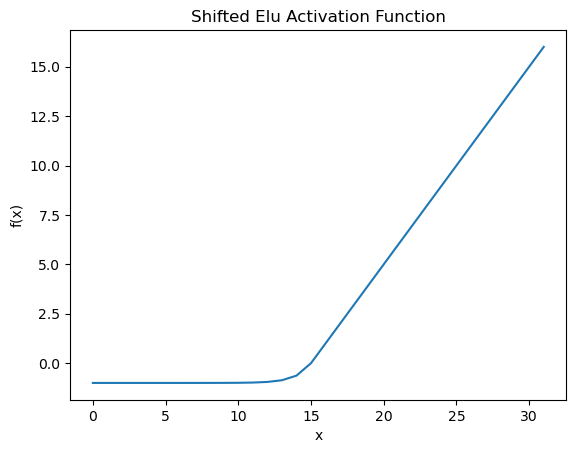

In [2]:
n_qubits = 5
x = np.arange(2**n_qubits)
y = []
for i in range(2**n_qubits):
    if x[i]>15:
        y.append(x[i]-15)
    else:
        y.append(1*(jnp.exp(x[i]-15)-1))  #alpha = 1
plt.plot(x,y)        
plt.title('Shifted Elu Activation Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

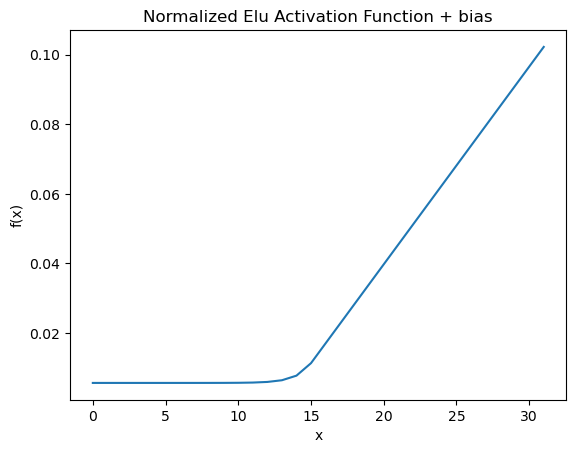

In [3]:
y = [y[i]+2 for i in range(len(y))]
area = trapezoid(y,x)

normalized_y = y/ area
plt.plot(x,normalized_y)
#plt.ylim(0,1)       
plt.title('Normalized Elu Activation Function + bias')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

### Implementing QCBM

In [4]:
#Defining squared maximum mean discrepancy (MMD) Loss function for Radial basis function (RBF) kernel
class MMD:
    
    def __init__(self, scales, space):
        #scales = list of guassian width (sigma)
        #space = data points x and y
        
        gammas = 1 / (2*(scales**2)).reshape(-1, 1, 1)  # Reshape gammas to (2, 1, 1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0) / len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)

In [5]:
from functools import partial

class QCBM:
    
    def __init__(self,circ,mmd,py):
        self.circ = circ    #qcbm circuit
        self.mmd = mmd      #MMD call
        self.py = py        #target distribution pi(x)
    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self,params):
        px = self.circ(params)  #Obtained probability distribution
        return self.mmd(px,self.py), px

## QCBM for Elu

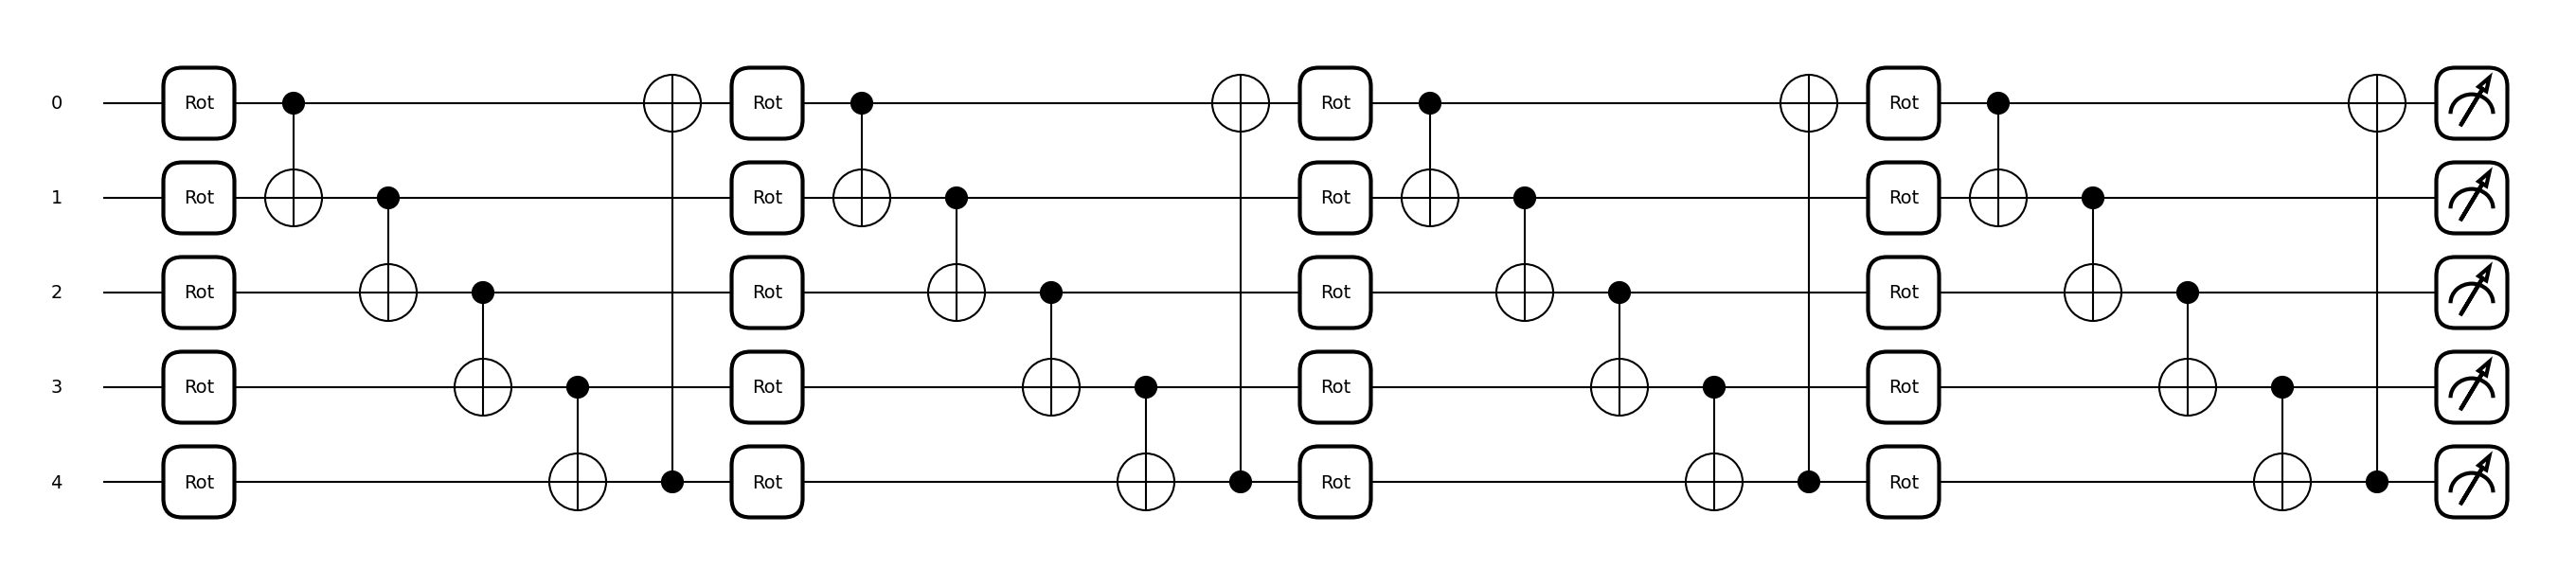

In [6]:
dev = qml.device("default.qubit",wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)

@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights,wires=range(n_qubits), ranges=[1]*n_layers)
    return qml.probs()
jit_circuit = jax.jit(circuit)
qml.draw_mpl(circuit,level="device")(weights)
plt.show()

In [7]:
## Training QCBM

def update_step(params,opt_state):
    #params = parameters of circuit (weights)
    #opt_state = optimizer state
    
    #calculating gradient
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    
    #updating the optimizer state and parameters
    updates, opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    
    #calculating the KL Divergence
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    
    return params, opt_state, loss_val, kl_div

Text(0, 0.5, 'KL Divergence')

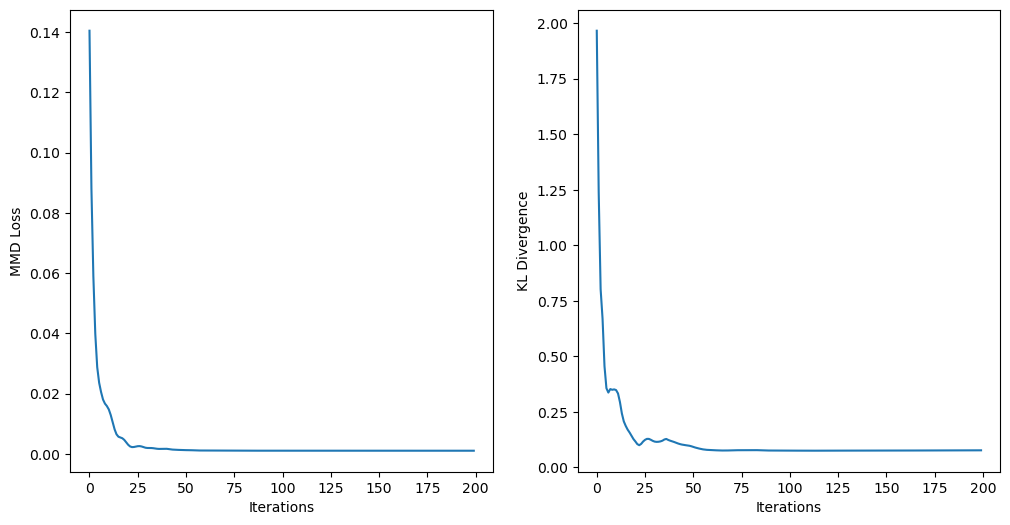

In [8]:
#Calling MMD class
bandwidth = jnp.array([0.25,16])
space = jnp.linspace(-1,1,2**n_qubits)
mmd = MMD(bandwidth,space=x)

#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=normalized_y)

#Call an optimizer
opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 200

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    
    # if i%10==0:
    #     print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div}")
    
    history.append(loss_val)
    divs.append(kl_div)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(history)
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('MMD Loss')

ax[1].plot(divs)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('KL Divergence')

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_24723/3270523478.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x,normalized_y,linestyle='-',label='$\pi(x)$')


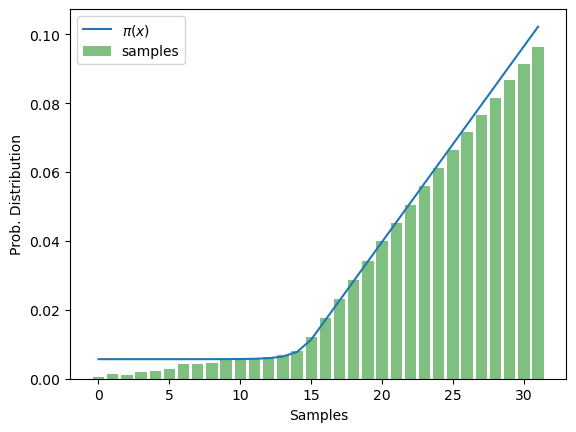

In [9]:
qcbm_probs = qcbm.circ(weights)

plt.plot(x,normalized_y,linestyle='-',label='$\pi(x)$')
plt.bar(x,qcbm_probs,color='green',alpha=0.5,label='samples')

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()

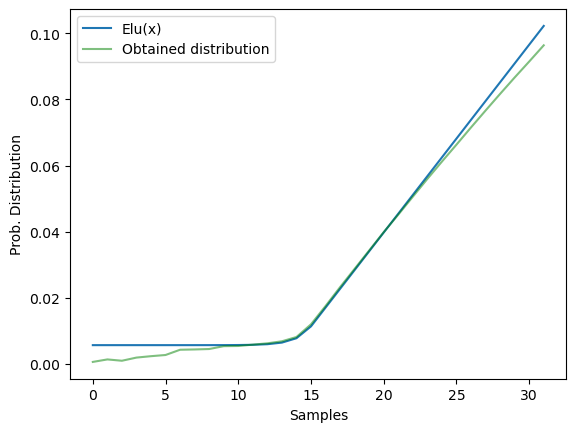

In [10]:
plt.plot(x,normalized_y,linestyle='-',label='Elu(x)')
plt.plot(x,qcbm_probs,color='green',alpha=0.5,label='Obtained distribution')
plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()